In [1]:
import pandas as pd
import seaborn as sns
from wordcloud import STOPWORDS
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
from sklearn.metrics import cohen_kappa_score
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import StratifiedKFold


2024-07-28 08:16:15.747905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 08:16:15.748015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 08:16:15.883944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')

In [3]:
train_df.drop('essay_id', axis=1, inplace=True)
train_df

,full_text,score
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...
17302,"the story "" The Challenge of Exploing Venus "" ...",2
17303,Technology has changed a lot of ways that we l...,4
17304,If you don't like sitting around all day than ...,2
17305,"In ""The Challenge of Exporing Venus,"" the auth...",1


In [4]:
print('Text:   ', train_df['full_text'][0])
print('\nScore:  ', train_df['score'][0])

Text:    Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely "car free" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some wher

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  17307 non-null  object
 1   score      17307 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 270.5+ KB


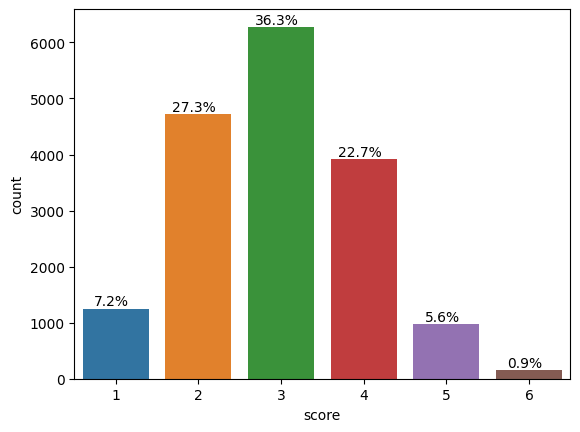

In [6]:
ax = sns.countplot(data=train_df, x='score')

total = len(train_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


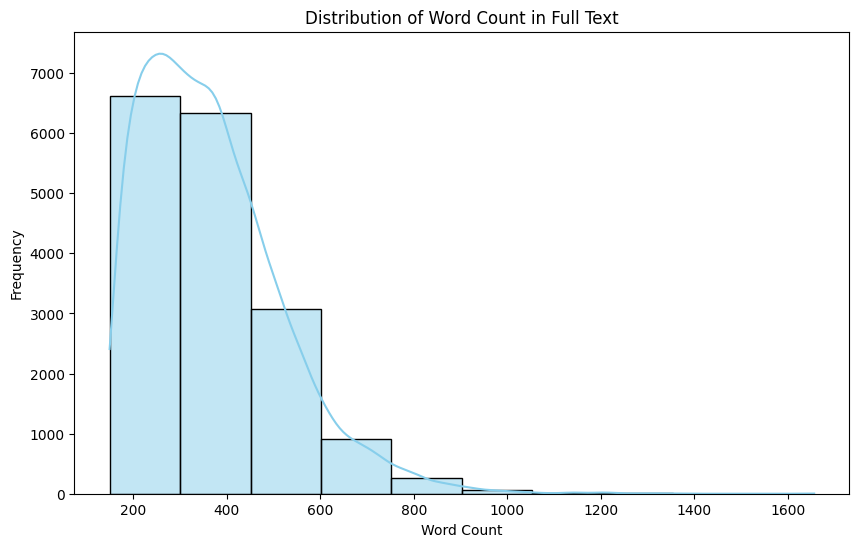

In [27]:
train_df['word_count'] = train_df['full_text'].str.split().str.len()

plt.figure(figsize=(10, 6))
sns.histplot(train_df['word_count'], bins=10, kde=True, color='skyblue')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count in Full Text')
plt.show()

In [7]:
# def generate_ngrams(text, n_gram):
#     token = [word for word in text.lower().split(' ') if word != '' if word != ' ' if word not in STOPWORDS]
#     ngrams = zip(*[token[i:] for i in range(n_gram)])
#     return [' '.join(ngram) for ngram in ngrams]
# essay_score1_unigrams = defaultdict(int)
# essay_score2_unigrams = defaultdict(int)
# essay_score3_unigrams = defaultdict(int)
# essay_score4_unigrams = defaultdict(int)
# essay_score5_unigrams = defaultdict(int)
# essay_score6_unigrams = defaultdict(int)

# for full_text in train_df[train_df['score'] == 1]['full_text']:
#     for word in generate_ngrams(full_text, 2):
#         essay_score1_unigrams[word] += 1
# for full_text in train_df[train_df['score'] == 2]['full_text']:
#     for word in generate_ngrams(full_text, 2):
#         essay_score2_unigrams[word] += 1
# for full_text in train_df[train_df['score'] == 3]['full_text']:
#     for word in generate_ngrams(full_text, 2):
#         essay_score3_unigrams[word] += 1
# for full_text in train_df[train_df['score'] == 4]['full_text']:
#     for word in generate_ngrams(full_text, 2):
#         essay_score4_unigrams[word] += 1
# for full_text in train_df[train_df['score'] == 5]['full_text']:
#     for word in generate_ngrams(full_text, 2):
#         essay_score5_unigrams[word] += 1
# for full_text in train_df[train_df['score'] == 6]['full_text']:
#     for word in generate_ngrams(full_text, 2):
#         essay_score6_unigrams[word] += 1
# df_essay_score1_unigrams = pd.DataFrame(sorted(essay_score1_unigrams.items(), key = lambda x : x[1], reverse = True))
# df_essay_score2_unigrams = pd.DataFrame(sorted(essay_score2_unigrams.items(), key = lambda x : x[1], reverse = True))
# df_essay_score3_unigrams = pd.DataFrame(sorted(essay_score3_unigrams.items(), key = lambda x : x[1], reverse = True))
# df_essay_score4_unigrams = pd.DataFrame(sorted(essay_score4_unigrams.items(), key = lambda x : x[1], reverse = True))
# df_essay_score5_unigrams = pd.DataFrame(sorted(essay_score5_unigrams.items(), key = lambda x : x[1], reverse = True))
# df_essay_score6_unigrams = pd.DataFrame(sorted(essay_score6_unigrams.items(), key = lambda x : x[1], reverse = True))

In [8]:
# N = 100
# fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
# plt.tight_layout()

# sns.barplot(y=df_essay_score1_unigrams[0].values[:N], x=df_essay_score1_unigrams[1].values[:N], ax=axes[0], color='red')
# sns.barplot(y=df_essay_score6_unigrams[0].values[:N], x=df_essay_score6_unigrams[1].values[:N], ax=axes[1], color='green')

# for i in range(2):
#     axes[i].spines['right'].set_visible(False)
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')
#     axes[i].tick_params(axis='x', labelsize=13)
#     axes[i].tick_params(axis='y', labelsize=13)

# axes[0].set_title(f'Top {N} df_essay_score1_unigrams', fontsize=15)
# axes[1].set_title(f'Top {N} df_essay_score6_unigrams', fontsize=15)

# plt.show()

In [9]:
class_weights = (1 - (train_df["score"].value_counts().sort_index() / len(train_df))).values
class_weights

array([0.92765933, 0.72710464, 0.63714104, 0.77315537, 0.94395331,
       0.99098631])

In [10]:
class_weights = torch.from_numpy(class_weights).float().to("cuda")#.to("mps")
class_weights

tensor([0.9277, 0.7271, 0.6371, 0.7732, 0.9440, 0.9910], device='cuda:0')

In [11]:
checkpoint = 'microsoft/deberta-v3-small'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from sklearn.model_selection import train_test_split

X = train_df['full_text']
y = train_df['score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y , random_state=53)

data_train = Dataset.from_dict({
    'full_text': X_train.tolist(),  # Chuyển đổi Series thành danh sách
    'labels': [s - 1 for s in y_train]  # Giảm giá trị của label đi 1
})
data_val = Dataset.from_dict({
    'full_text': X_val.tolist(),  # Chuyển đổi Series thành danh sách
    'labels': [s - 1 for s in y_val]  # Giảm giá trị của label đi 1
})

In [13]:
def tokenize_function(example):
    return tokenizer(example["full_text"], truncation=True, max_length=1024)

In [14]:
tokenized_data_train = data_train.map(tokenize_function, batched=True)
tokenized_data_val = data_val.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

In [15]:
def compute_metrics(eval_pred):
    
    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights='quadratic')
    results = {
        'qwk': qwk
    }
    return results


from torch import nn, torch
class WeightedLossTrainer(Trainer):

    def compute_loss(self, model, inputs, return_outputs=False):

        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")

        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_func(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [16]:
training_args = TrainingArguments(
    output_dir = f'weighted_results',
    fp16=True,
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    metric_for_best_model='qwk',
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to='none',
    warmup_ratio=0.0,
    lr_scheduler_type='linear', # "cosine" or "linear" or "constant"
    optim='adamw_torch',
    logging_first_step=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
trainer = WeightedLossTrainer( 
            model=model,
            args=training_args,
            train_dataset=tokenized_data_train,
            eval_dataset=tokenized_data_val,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Qwk
1,0.926600,0.884338,0.785532
2,0.830600,0.992665,0.767131
3,0.764900,0.914690,0.805904
4,0.697000,0.949069,0.800276


TrainOutput(global_step=13848, training_loss=0.8285453783542968, metrics={'train_runtime': 4116.8209, 'train_samples_per_second': 13.452, 'train_steps_per_second': 3.364, 'total_flos': 8880503345362800.0, 'train_loss': 0.8285453783542968, 'epoch': 4.0})

In [19]:
model.save_pretrained("./my_model")

In [20]:
tokenizer.save_pretrained('auto_scoring_tokenizer')

('auto_scoring_tokenizer/tokenizer_config.json',
 'auto_scoring_tokenizer/special_tokens_map.json',
 'auto_scoring_tokenizer/spm.model',
 'auto_scoring_tokenizer/added_tokens.json',
 'auto_scoring_tokenizer/tokenizer.json')

In [21]:
test_data = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
test_data

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [22]:
tokenized = tokenizer(test_data['full_text'].tolist(),padding=True,truncation=True, return_tensors="pt")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [23]:
import torch
device = torch.device("cpu")
model.to(device)
model.eval()

    # Dự đoán
with torch.no_grad():
    outputs = model(**tokenized)

    # Truy cập các logits từ kết quả dự đoán
logits = outputs.logits

    # Nếu là bài toán phân loại, lấy ra các nhãn dự đoán
predicted_labels = torch.argmax(logits, dim=-1) + 1

print(predicted_labels)

tensor([2, 3, 4])


In [24]:
trainer.save_model('weighted_trainning_model')